In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import string

## Data Import and Cleaning

In [2]:
#Import Data
duplicate_ids = np.load('duplicate_fuzzy_ids.npy')
r_golbeck = pd.read_csv('Golbeck/onlineHarassmentDataset.tsv', delimiter='\t', encoding='latin-1')
r_golbeck.head()

,ID,Code,Tweet
0,1,H,@Grumpy_P_Sloth @deanesmay feminists argue for...
1,2,H,1948Army of England helped the Jews to occupy ...
2,3,H,Dutch Leader Says Europe to collapse In 6 Week...
3,4,H,RT @__DeLay: The next day the Romans and the J...
4,5,H,RT @Bakersman_Joe: When Hitler Invited The Jew...


In [3]:
#Python version of Ruby preprocessing script accessible here: https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
from preprocessTwitter import tokenize 

def clean_tweets(tweet):
    '''
    This function applies additional cleaning steps to the tweets 
    in order for the word embeddings to capture more semantic/syntactic information
    '''
    tweet = re.sub('^RT:? ','<rt> ',tweet) #Assign special char to RTs
    tweet = re.sub('RT@','<rt> @',tweet) #Split out RT and user mention when overlapping
    tweet = re.sub('via@','via @',tweet) #Split out 'via' and user mention when overlapping
    tweet = re.sub(r'https?: ?/ ?/t(.co( )?)?/?[A-Za-z0-9é]*|https?:\\/\\/t.co\\/[A-Za-z0-9]*é?|https?(: / /)?é?', '<url>', tweet) #Assign special char to URLs (Python script missing some cases that I do not)
    tweet = re.sub(r'<url>é|<url> ?\.c[oé]*$', '<url>', tweet, flags=re.IGNORECASE) 
    tweet = re.sub(r"'", '', re.sub(r'"', '', tweet)) #Get rid of single and double quotes (admittedly loses some context here)
    tweet = re.sub('anti-', 'anti ', tweet, flags=re.IGNORECASE) #Capture 'anti' or 'non' prefix as its own word 
    tweet = re.sub('#anti', '#anti ', tweet, flags=re.IGNORECASE)
    tweet = re.sub(' anti', ' anti ', tweet, flags=re.IGNORECASE)
    tweet = re.sub('non-', 'non ', tweet, flags=re.IGNORECASE)
    tweet = re.sub('&amp;?', '&', tweet, flags=re.IGNORECASE) #Put ampersand in recognizable format
    #Clean some known hateful terms that are in the data (e.g. "whitepower") to extract meaning from hashtags
    tweet = re.sub('#white', '#white ', tweet, flags=re.IGNORECASE)
    tweet = re.sub('waronwhite', 'war on white', tweet, flags=re.IGNORECASE)
    tweet = re.sub('whitegenocide', 'white genocide', tweet, flags = re.IGNORECASE)
    tweet = re.sub('whitelivesmatter', 'white lives matter', tweet, flags = re.IGNORECASE)
    tweet = re.sub('blacklivesmatter', 'black lives matter', tweet, flags = re.IGNORECASE)
    tweet = re.sub('livesmatter', 'lives matter', tweet, flags = re.IGNORECASE)
    tweet = re.sub('alllive', 'all live', tweet, flags = re.IGNORECASE)
    tweet = re.sub('bluelive', 'blue live', tweet, flags = re.IGNORECASE)
    tweet = re.sub('whitepower', 'white power', tweet, flags = re.IGNORECASE)
    tweet = re.sub('#fuck', '#fuck ', tweet, flags=re.IGNORECASE)
    tweet = re.sub('fuckniggers', 'fuck niggers', tweet, flags=re.IGNORECASE)
    tweet = re.sub('sjw', 'social justice warrior', tweet, flags=re.IGNORECASE)
    tweet = tweet.strip() #Strip whitespace
    return tweet

In [4]:
r_golbeck['clean_tweet'] = r_golbeck['Tweet'].apply(clean_tweets) #Apply my own cleaning steps
r_golbeck['clean_tweet'] = r_golbeck['clean_tweet'].apply(tokenize) #Then apply the ones implemented in Ruby preprocessing script
r_golbeck['clean_tweet'] = r_golbeck['clean_tweet'].apply(lambda x:re.sub('><', '> <', x)) #Finally, separate any special characters that are overlapping/touching
r_golbeck.head()

,ID,Code,Tweet,clean_tweet
0,1,H,@Grumpy_P_Sloth @deanesmay feminists argue for...,<user> <user> feminists argue for raising mini...
1,2,H,1948Army of England helped the Jews to occupy ...,<number>army of england helped the jews to occ...
2,3,H,Dutch Leader Says Europe to collapse In 6 Week...,dutch leader says europe to collapse in <numbe...
3,4,H,RT @__DeLay: The next day the Romans and the J...,<rt> <user> : the next day the romans and the ...
4,5,H,RT @Bakersman_Joe: When Hitler Invited The Jew...,<rt> <user> : when hitler invited the jews to ...


In [5]:
#Drop tweets that are actually multiple tweets in one (data entry errors in the underlying dataset I received from authors)
indexes = []
for i in range(len(r_golbeck['clean_tweet'])):
  l = len(str.split(r_golbeck['clean_tweet'].iloc[i], ' '))
  if l > 100:
    indexes.append(i)

r_golbeck.drop(indexes, axis=0, inplace=True)

#Also drop tweets that are duplicates based on fuzzy matching exercise
r_golbeck = r_golbeck[np.isin(r_golbeck['ID'], duplicate_ids, invert=True)]
r_golbeck.shape

(19664, 4)

# BOW and Tf-Idf for Logistic Regression

In [6]:
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
snowball = SnowballStemmer('english') 
punct = [p for p in string.punctuation if p not in ['<','>']]

def stem_no_punct(tweet):
  tokens = nltk.regexp_tokenize(tweet, '\S+') #Separate tweets into tokens
  tokens = [snowball.stem(t) for t in tokens if t not in punct] #Apply stemming and remove punctuation
  return tokens

r_golbeck['tokens'] = r_golbeck['clean_tweet'].apply(stem_no_punct) #New column serves as data for Logistic Regression only
r_golbeck.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/judahaxelrod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ID,Code,Tweet,clean_tweet,tokens
0,1,H,@Grumpy_P_Sloth @deanesmay feminists argue for...,<user> <user> feminists argue for raising mini...,"[<user>, <user>, feminist, argu, for, rais, mi..."
1,2,H,1948Army of England helped the Jews to occupy ...,<number>army of england helped the jews to occ...,"[<number>armi, of, england, help, the, jew, to..."
3,4,H,RT @__DeLay: The next day the Romans and the J...,<rt> <user> : the next day the romans and the ...,"[<rt>, <user>, the, next, day, the, roman, and..."
7,8,H,"RT @CharlesFinch: ""The Jews were provided free...",<rt> <user> : the jews were provided free tran...,"[<rt>, <user>, the, jew, were, provid, free, t..."
9,10,H,RT @HeymanHustle: .. @MichelleDBeadle I can do...,<rt> <user> : . <repeat> <user> i can do news ...,"[<rt>, <user>, <repeat>, <user>, i, can, do, n..."


## Frequency Distribution for Stemmed Tokens

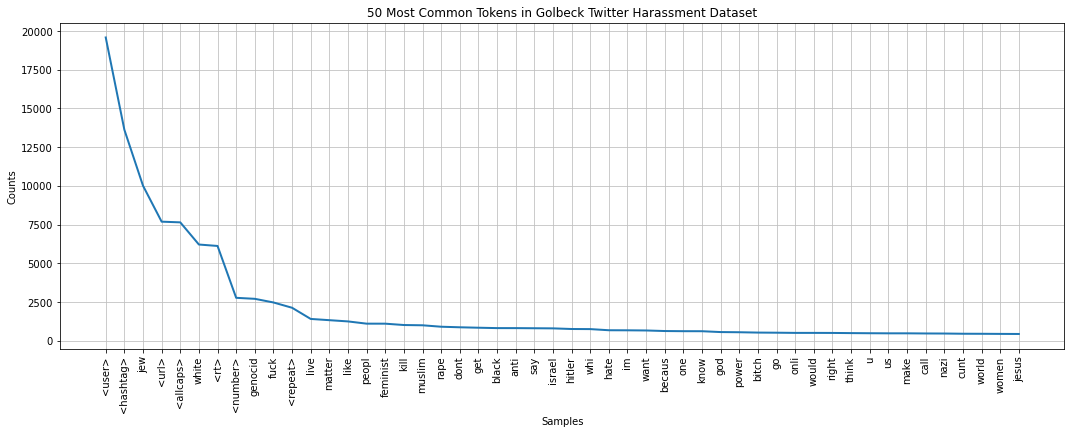

In [10]:
all_words = [token for tweet in r_golbeck['tokens']
                  for token in tweet]
fd = nltk.FreqDist(w for w in all_words if w not in stop)

#Plot 50 most frequently occurring tokens
fig = plt.figure(figsize=(18,6))
fd.plot(50, title = '50 Most Common Tokens in Golbeck Twitter Harassment Dataset');
fig.savefig('img/freq_dist.pdf', bbox_inches='tight')

## Building Pre-Trained Word Embeddings
Much of the code in this section is used directly from [this Keras tutorial](https://keras.io/examples/nlp/pretrained_word_embeddings/#load-pretrained-word-embeddings)

In [10]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
#Build a vectorizer that considers the top 20,000 tokens in the dataset
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=60, standardize=None)

tweets = tf.data.Dataset.from_tensor_slices(r_golbeck['clean_tweet']).batch(128)
vectorizer.adapt(tweets)

#Each token in a given tweet is indexed by the vectorizer and then right-padded with zeros up to length 60
vectorizer([["this is a sample tweet"]]).numpy()

array([[ 35,  17,  15,   1, 414,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]])

In [17]:
#Download and Unzip GloVe and FastText embeddings
!curl -LO http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip -q glove.twitter.27B.zip

!curl -LO https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip -q crawl-300d-2M.vec.zip

In [27]:
path_to_glove_file = "glove.twitter.27B.100d.txt"
path_to_ft_file = "crawl-300d-2M.vec"

vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

def build_embedding(path, name, embedding_dim):
  # Create dictionary mapping each word to its embedding vector
    embeddings_index = {}
    with open(path) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "float", sep=" ")
            embeddings_index[word] = coefs
    print("Found {} word vectors in {}".format(len(embeddings_index), name))

    hits = 0
    misses = 0
    miss_list = []

  # Prepare embedding matrix
    embedding_matrix = np.zeros((20000, embedding_dim))
    for word, index in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
            embedding_matrix[index] = embedding_vector
            hits += 1
        else:
            misses += 1
            miss_list.append(word)
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix

#Create embeddings for both GloVe (100D) and FastText (300D)
glove_embedding = build_embedding(path_to_glove_file, 'GloVe', 100)
ft_embedding = build_embedding(path_to_ft_file, 'fastText', 300)

Found 1193514 word vectors in GloVe
Converted 15438 words (4562 misses)
Found 1999996 word vectors in fastText
Converted 15606 words (4394 misses)


In [28]:
#Get list of tokens for dimension reduction visualization
words20k = [w for w in word_index.keys()]

## Save Data for Later Re-Importing

In [29]:
#After saving, I then upload all of these data objects to Google Drive for use in Colab notebook
np.save('embedding100.npy', glove_embedding)
np.save('fasttext300.npy', ft_embedding)
np.save('words20k.npy', words20k)
r_golbeck.to_csv('c_golbeck.csv')